# 画像のノイズ除去

## 目的
このチュートリアルでは

* 画像中のノイズを除去するNon-local Means Denoising(パターン保存ノイズ除去)アルゴリズムを学ぶ．
* [cv2.fastNlMeansDenoising()](http://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html?highlight=cv2.fastnlmeansdenoising#cv2.fastNlMeansDenoisingMulti) や [cv2.fastNlMeansDenoisingColored()](http://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html?highlight=cv2.fastnlmeansdenoising#cv2.fastNlMeansDenoisingColored) などの関数を学ぶ．

## 理論
これまでのチュートリアルでは、ガウシアン・フィルタリングや中央値フィルタリングなどいろいろな画像平滑化技術を学んできた．これらの手法はノイズが小さい時にはうまく動いてくれる．注目画素に対し、その近傍のガウス重み平均などによって得られた値で置き換えるようなものであった。要するにノイズ除去は注目画素の近傍という局所な処理で行われるものであった．

ノイズにはある性質がある．一般的には平均ゼロのランダムな値と考えられる．ノイズがかかった画素値を次式で表す: $p = p_0 + n$ ：ここで $p_0 $はノイズが含まれない本来の画素値であり、 $n$ は画素に加えられたノイズの値である。いろいろな画像からたくさんの画素を集め(その個数を$ N$)とする)、その平均を求めると理想的には、ノイズの平均値がゼロなので，$p = p_0$ となるはずである．

これは次のようにして簡単に確かめることができる．ある場所にカメラを固定し数秒間撮影する。これにより同じ場所を写した大量のフレーム(もしくは静止画)が得られる．次に動画のすべてのフレームの平均値を計算するコードを書いてみる(これはとっても簡単にできるだろう)．そしてその結果と最初のフレームとを比較してみよう．これでノイズ除去の効果が分かる．残念ながら、この簡単な方法はカメラや情景の動きに対し頑健ではない．また，他には画像がなく、ノイズ付きの画像一枚しか使えない場合もよくある．

ここでのアイデアは単純で，ノイズを平均化によって除去するために似たような画像を何枚か必要とする。画像の中の小さな領域(例えば$5\times 5$のサイズの領域)を考えてみよう．この領域が、同じ画像の別の場所にも現れる可能性は高いだろう．時にはその近くにあるかもしれない．そこで、このような似た小領域を使ってその平均を取ってみてはどうだろうか?特定の小領域に対してなら問題はないだろう．さて、次の画像をみてみよう:

![Similar patches](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/nlm_patch.jpg)

画像中の青いパッチ同士は似ている．緑のパッチ同士も似ている．画像のひとつの画素に注目し、その周りの小さな「窓」領域を取り出し、その画像で似た窓領域を探し，これらの窓領域すべての平均を求め、対象画素をその結果で置き換える．これがNon-Local Means Denoising(パターン保存ノイズ除去法)である．既にみた平滑化法に比べ処理時間はかかるものの，これは非常に良い結果が得られる．これについての詳細な情報とオンラインデモは [補足資料の一番目のリンク](http://www.ipol.im/pub/art/2011/bcm_nlm/) によって得られる．

カラー画像に対してノイズ除去を行うには，画像を [CIE LAB色空間](https://ja.wikipedia.org/wiki/Lab%E8%89%B2%E7%A9%BA%E9%96%93) に変換してからL成分とAB成分に対して独立してノイズ除去を適用する．



## OpenCVによるノイズ除去
OpenCVはこの手法に関して次の4つの関数を提供している．

1. [cv2.fastNlMeansDenoising()](http://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html?highlight=cv2.fastnlmeansdenoising#cv2.fastNlMeansDenoising) - 一枚のグレー・スケール画像を扱う
2. [cv2.fastNlMeansDenoisingColored()](http://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html?highlight=cv2.fastnlmeansdenoising#cv2.fastNlMeansDenoisingColored) - 一枚のカラー画像を扱う
3. [cv2.fastNlMeansDenoisingMulti()](http://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html?highlight=cv2.fastnlmeansdenoising#cv2.fastNlMeansDenoisingMulti) - 短時間に撮影された一連のグレー・スケール画像を扱う
4. [cv2.fastNlMeansDenoisingColoredMulti()](http://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html?highlight=cv2.fastnlmeansdenoising#cv2.fastNlMeansDenoisingColoredMulti) - 短時間に撮影された一連のカラー画像を扱う

共通する引数:
* `h` : フィルタの強さを決定するパラメータ．値が大きければノイズをより良く消せるが，画像の細かい部分も取り除く(10であればOK)．
* `hForColorComponents` : `h`と同様だが、カラー画像だけのパラメータ(普通`h`と同じ値)．
* `templateWindowSize` : テンプレートとなるウィンドウの大きさ．奇数でなければならない(推奨値は7)．
* `searchWindowSize` : 探索ウィンドウの大きさ．奇数でなければならない(推奨値は21)．

これらのパラメータに関する詳細な説明は[補足資料の一番目のリンク](http://www.ipol.im/pub/art/2011/bcm_nlm/)を参照すること．

ここでは2番目と3番目の関数を使用してみる．残りの関数は自分で試してみよう．

### 1. [cv2.fastNlMeansDenoisingColored(src{, dst{, h{, hColorComponents{, templateWindowSize{, searchWindowSize}}}}})](http://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html?highlight=cv2.fastnlmeansdenoising#cv2.fastNlMeansDenoisingColored)

上述したように、これはカラー画像に対するノイズ除去のための関数である(ノイズは白色雑音を想定)．その例は以下: ([使用するノイズ画像](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_photo/py_non_local_means/noisedImage1.png))

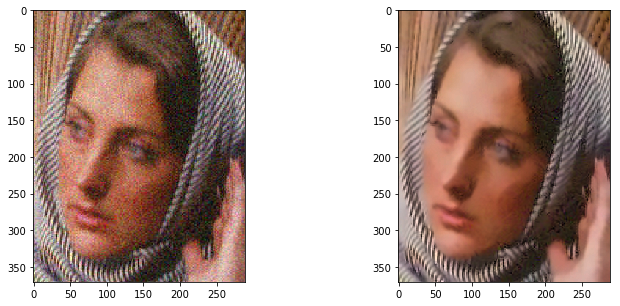

In [4]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('noisedImage1.png')

dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

plt.figure(figsize=(12,5))
plt.subplot(121),plt.imshow(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
plt.subplot(122),plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
plt.show()

### 2. [cv2.fastNlMeansDenoisingMulti(srcImgs, imgToDenoiseIndex, temporalWindowSize{, dst{, h{, templateWindowSize{, searchWindowSize}}}})](http://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html?highlight=cv2.fastnlmeansdenoising#cv2.fastNlMeansDenoisingMulti)
今度は動画像に対してこの手法を適用する．第1引数`srcImgs`は劣化画像列のリスト, 第2引数`imgToDenoiseIndex` はノイズ除去を適用する画像のフレーム番号, 第3引数 `temporalWindowSize` はノイズ除去に使うための近傍フレームの数(奇数)を指定する．このように設定すると、あるフレームの画像に対しその前後 `temporalWindowSize` 枚の画像によってノイズ除去を行う．例えば入力画像として5フレームのリストを与え、`imgToDenoiseIndex = 2`， `temporalWindowSize = 3`とすると，フレーム番号2の画像のノイズ除去を行うために、フレーム番号1番、2番, 3番の画像が使われる．それではコードを見てみよう:

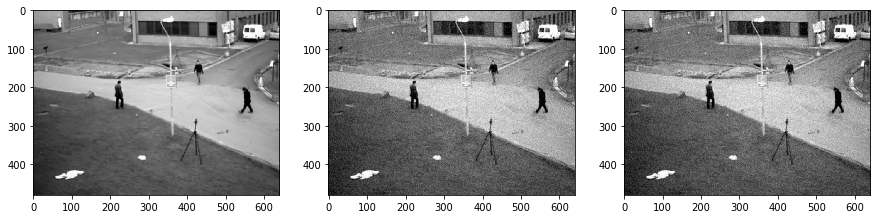

In [7]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

cap = cv2.VideoCapture('test.avi')

# 先頭5フレームのリストを作る
img = [cap.read()[1] for i in range(5)]

# そのすべてをグレー・スケールに変換
gray = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in img]

# すべてを float64 に変換
gray = [np.float64(i) for i in gray]

# 分散25のノイズを生成
noise = np.random.randn(*gray[1].shape)*10

# このノイズを画像に足す
noisy = [i+noise for i in gray]

# 画像を uint8に戻す
noisy = [np.uint8(np.clip(i,0,255)) for i in noisy]

# 3番めのフレームを、5つのフレームすべてを使ってノイズ除去
dst = cv2.fastNlMeansDenoisingMulti(noisy, 2, 5, None, 4, 7, 35)

plt.figure(figsize=(15,10))
plt.subplot(131),plt.imshow(gray[2],'gray')
plt.subplot(132),plt.imshow(noisy[2],'gray')
plt.subplot(133),plt.imshow(dst,'gray')
plt.show()

この処理は計算に時間がかかる．上記の図は左から順に入力画像，劣化画像，復元画像を載せている．

## 補足資料
1. [http://www.ipol.im/pub/art/2011/bcm_nlm/](http://www.ipol.im/pub/art/2011/bcm_nlm/) (このチュートリアルで紹介したノイズ除去法の詳細，オンラインでもなどが載っている．ぜひ参照せよ．)
2. [coursera のオンライン講義](https://www.coursera.org/course/images)